## Import required libraries

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [29]:
df = pd.read_csv('House_price_prediction_data.csv')

In [30]:
df.shape

(1460, 81)

In [31]:
np.where(df.isnull().sum() !=0)

(array([ 3,  6, 25, 26, 30, 31, 32, 33, 35, 42, 57, 58, 59, 60, 63, 64, 72,
        73, 74]),)

In [32]:
df = df.replace('NA', np.nan)

In [33]:
df.loc[:, df.isnull().any()].isnull().sum()

,0
LotFrontage,259
Alley,1369
MasVnrType,872
MasVnrArea,8
BsmtQual,37
BsmtCond,37
BsmtExposure,38
BsmtFinType1,37
BsmtFinType2,38
Electrical,1


## Removing columns with more than 30% missing data

In [34]:
df.drop(df.columns[df.isnull().sum() > 0.3 * len(df)], axis=1, inplace=True)

In [35]:
df.shape

(1460, 75)

In [36]:
df.loc[:, df.isnull().any()].isnull().sum()

,0
LotFrontage,259
MasVnrArea,8
BsmtQual,37
BsmtCond,37
BsmtExposure,38
BsmtFinType1,37
BsmtFinType2,38
Electrical,1
GarageType,81
GarageYrBlt,81


Removing Unnecessary categorical columns

In [37]:
df_num = df.select_dtypes(include=['int64', 'float64'])

,SalePrice
count,1460.000000
mean,180921.195890
std,79442.502883
min,34900.000000
25%,129975.000000
50%,163000.000000
75%,214000.000000
max,755000.000000


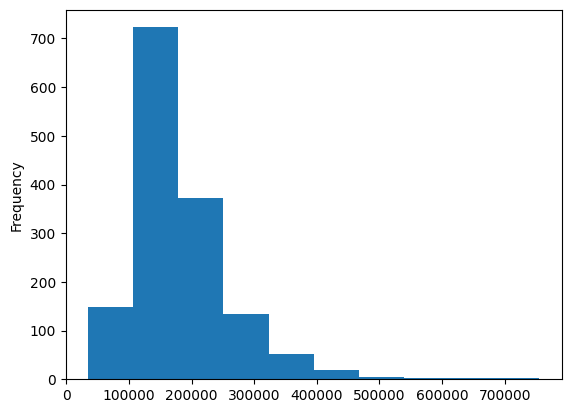

In [38]:
df_num["SalePrice"].plot.hist()
df_num["SalePrice"].describe()

In [39]:
df_num.loc[:, df.isnull().any()].isnull().sum()

,0
LotFrontage,259
MasVnrArea,8
GarageYrBlt,81


Finding correlated columns and dropping them if they are more than 80% correlated

In [40]:
def correlation (dataset, threshold):
    col_corr= set()
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:
              colname = corr_matrix.columns [i]
              col_corr.add(colname)

    return col_corr

In [41]:
correlation(df_num, 0.8)

{'1stFlrSF', 'GarageArea', 'GarageYrBlt', 'TotRmsAbvGrd'}

In [42]:
df_num.drop(correlation(df_num, 0.8), axis=1, inplace=True)
df_num.shape

(1460, 34)

In [43]:
df_num.loc[:, df.isnull().any()].isnull().sum()

,0
LotFrontage,259
MasVnrArea,8


LotFrontage is related to

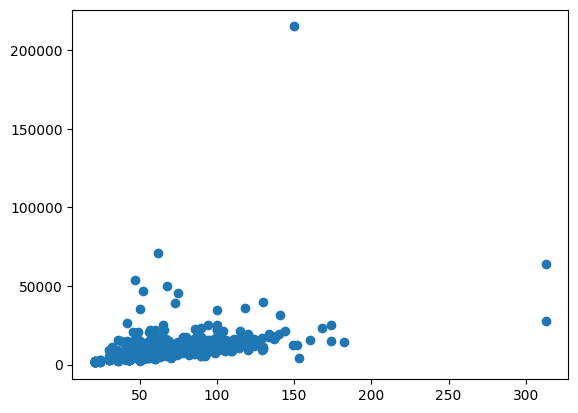

In [44]:
plt.scatter(df_num['LotFrontage'], df_num['LotArea'])


In [45]:
corr_matrix = df_num.corr()
corr_matrix.loc["LotFrontage", :].sort_values(ascending = False).head(5)

,LotFrontage
LotFrontage,1.000000
LotArea,0.426095
GrLivArea,0.402797
TotalBsmtSF,0.392075
SalePrice,0.351799


Only LotArea is somewhat correlated to LotFrontage, for missing values in LotFrontage - taking the mean by grouping through LotArea (bins-10)

In [46]:
df_num["LotArea_bin"] = pd.qcut(df_num["LotArea"], q=10, duplicates='drop')
df_num["LotFrontage"] = df_num.groupby("LotArea_bin")["LotFrontage"].transform(lambda x: x.fillna(x.mean()))
df_num["LotFrontage"].isnull().sum()

/tmp/ipython-input-548051980.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_num["LotFrontage"] = df_num.groupby("LotArea_bin")["LotFrontage"].transform(lambda x: x.fillna(x.mean()))


np.int64(0)

In [47]:
df_num.loc[:, df_num.isnull().any()].isnull().sum()

,0
MasVnrArea,8


In [48]:
corr_matrix.loc["MasVnrArea", :].sort_values(ascending = False).head(5)

,MasVnrArea
MasVnrArea,1.000000
SalePrice,0.477493
OverallQual,0.411876
GrLivArea,0.390857
GarageCars,0.364204


Filling MasVnrArea by grouping OverallQual

In [49]:
df_num["OverallQual_bin"] = pd.qcut(df_num["OverallQual"], q=10, duplicates='drop')
df_num["MasVnrArea"] = df_num.groupby("OverallQual_bin")["MasVnrArea"].transform(lambda x: x.fillna(x.mean()))
df_num["MasVnrArea"].isnull().sum()

/tmp/ipython-input-3324126462.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_num["MasVnrArea"] = df_num.groupby("OverallQual_bin")["MasVnrArea"].transform(lambda x: x.fillna(x.mean()))


np.int64(0)

In [51]:
df_num.drop(["LotArea_bin", "OverallQual_bin"], axis=1, inplace=True)


KeyError: "['LotArea_bin', 'OverallQual_bin'] not found in axis"

Missing Value Handling is completed, Now Training the model

## Multi Linear Regression

In [53]:
X = df_num.drop("SalePrice", axis=1)
y = df_num["SalePrice"]

In [54]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1095, 33), (365, 33), (1095,), (365,))

In [55]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

Text(0.5, 1.0, 'X_train After scaling')

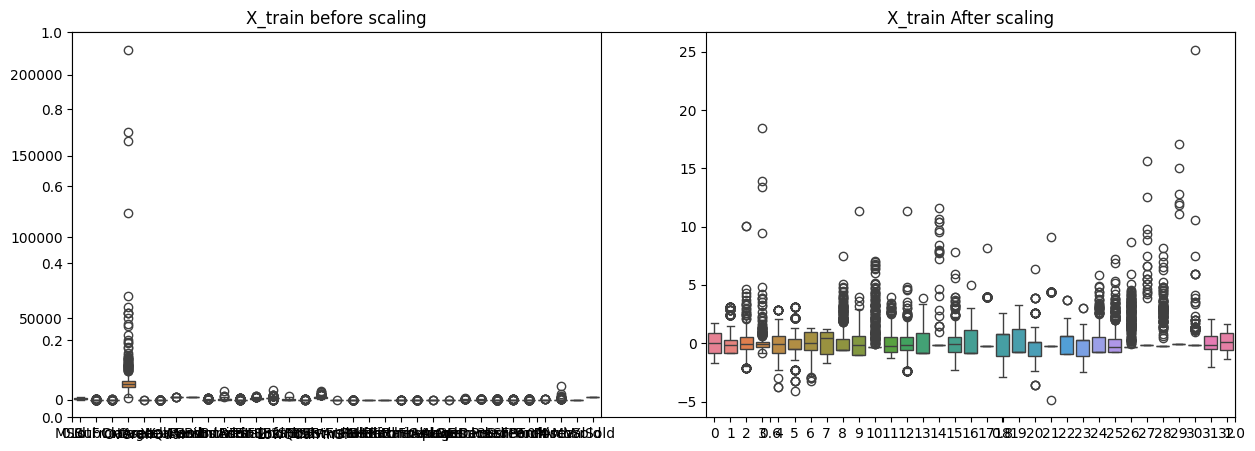

In [56]:
plt.subplots(figsize = (15,5))
plt.subplot(1,2,1)
sns.boxplot(X_train)
plt.title("X_train before scaling")
plt.subplot(1,2,2)
sns.boxplot(X_train_scaled)
plt.title("X_train After scaling")

In [57]:
from sklearn.linear_model import LinearRegression
l_r= LinearRegression()
l_r.fit(X_train_scaled, y_train)
y_pred_train = l_r.predict(X_train_scaled)
y_pred_test = l_r.predict(X_test_scaled)
score_scaled = l_r.score(X_test_scaled, y_test)
score_scaled # R2 score
l_r.coef_

array([ -909.95749614, -9581.63027276, -3520.64498621,  5044.46647976,
       25160.27415832,  3768.59374157,  9494.60067514,  4170.45944555,
        3750.43025161,  2929.44891542,  -484.12452255,  -802.09531131,
        2050.24275032,    64.22538509,  -118.04418934, 29211.19708443,
        6298.05354758,  -411.0762482 ,  2114.60809133,  -854.88128763,
       -4124.27448254, -1269.0184708 ,  3135.09660514,  9717.15857556,
        2911.34629567,  -730.1250789 ,  -193.1502693 ,  1351.75096529,
        3437.06409576, -1132.7251882 ,  -307.33155545,  -304.10937717,
        -618.68227122])

In [58]:
from sklearn.linear_model import LinearRegression
l_r= LinearRegression()
l_r.fit(X_train, y_train)
y_pred_train = l_r.predict(X_train)
y_pred_test = l_r.predict(X_test)
score_unscaled = l_r.score(X_test, y_test)
score_train = l_r.score(X_train, y_train)
print(score_train, score_unscaled)

0.8016363502835239 0.8226124965539823


Text(0, 0.5, 'Residuals')

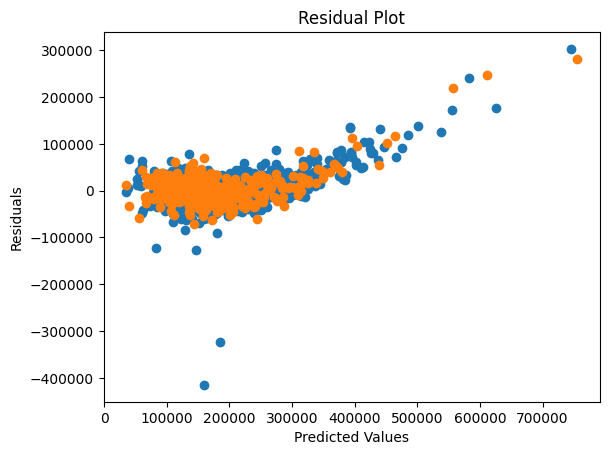

In [59]:
residual_train = y_train - y_pred_train
residual_test = y_test - y_pred_test
plt.scatter(y_train, residual_train)
plt.scatter(y_test, residual_test)
plt.title("Residual Plot")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")

## Lasso Regression

In [65]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score
lasso = Lasso(alpha = 10)
lasso.fit(X_train_scaled, y_train)
y_pred_train_lasso = lasso.predict(X_train_scaled)
y_pred_test_lasso = lasso.predict(X_test_scaled)
score_lasso = lasso.score(X_test_scaled, y_test)
score_train_lasso = lasso.score(X_train_scaled, y_train)
print(score_lasso, score_train_lasso)

lasso.coef_

0.8226297570132057 0.8016357085505126


array([ -901.90723216, -9554.73930543, -3494.78895126,  5032.84595976,
       25177.98401023,  3749.0865829 ,  9465.96791023,  4176.92800069,
        3746.87322346,  3759.7755998 ,  -196.4492842 ,     0.        ,
        1229.00271571,     0.        ,  -112.07511191, 29202.31354072,
        6286.52974984,  -402.77110117,  2116.67770885,  -816.96534473,
       -4097.42815041, -1271.38715409,  3130.25768251,  9718.98256836,
        2907.55939719,  -711.59041619,  -188.15323015,  1341.64201536,
        3422.89074422, -1121.48351921,  -296.64486848,  -291.7043696 ,
        -603.45802327])

## Ridge

In [61]:
from sklearn.linear_model import Ridge

ridge = Ridge()
ridge.fit(X_train_scaled, y_train)
y_pred_train_ridge = ridge.predict(X_train_scaled)
y_pred_test_ridge = ridge.predict(X_test_scaled)
score_ridge = ridge.score(X_test_scaled, y_test)
score_train_ridge = ridge.score(X_train_scaled, y_train)
print(score_ridge, score_train_ridge)
ridge.coef_

0.8226117560370353 0.8016351831287102


array([ -905.93086593, -9563.09896144, -3491.41808138,  5038.24476734,
       25126.62190974,  3754.25989241,  9442.70428493,  4197.74776704,
        3762.83705153,  2972.06090992,  -469.60367504,  -773.08466723,
        2128.31013621,   191.86926142,   -99.10750455, 28981.34851028,
        6282.96164492,  -419.01785538,  2155.40294809,  -845.01309615,
       -4102.8539974 , -1269.57493279,  3163.57558645,  9732.98188048,
        2920.92057991,  -725.69510333,  -196.43139603,  1353.9898637 ,
        3434.50033497, -1127.5101875 ,  -309.96097482,  -298.84799454,
        -618.80832512])